# Data Processing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

### Data Importing :
The raw data is in a folder called rawdata.

And the cleaned data is in another folder called cleaned data, which is cleaned by our "TwitterDataCleaning.py".


In [2]:
NorthAmerica = pd.read_csv("predata/NorthAmerica_Trends_cleaned1206.csv",sep = ",", header = 0)
TwitterData = NorthAmerica
len(TwitterData)
TwitterData.head()

,hashtags,location,tweet
0,NaN,NaN,actor morgan freeman unhurt plane forc land
1,youaintnomuslimbruv,NaN,london pride
2,youcandoitliam playliste1 cabasm,NaN,break newsth second messag the suprem leadersa...
3,mtvstars,NaN,one direct
4,indvssa,NaN,fascin watch amp even thoughenough variat bowler


## Target Hastags :

we will build a data frame for the target hashtags.

It could be counted directly or set up by the top trends data from the twitter api.

### Counting.

In [3]:
ListHashtags = TwitterData.hashtags.values
listwords = []
for tag in ListHashtags:
    if type(tag) == str:
        listwords +=tag.split(" ")
     

In [4]:
#d = {x:lista.count(x) for x in lista}
from collections import Counter
tags_count=Counter(listwords)

In [5]:
import heapq
N = 6 # N is the number of most used hashtags.
index_tag = heapq.nlargest(N, tags_count.values())
print index_tag
tags_dataframe = pd.DataFrame({'hashtag':tags_count.keys(),'number': np.array(tags_count.values())   })
tags_dataframe.head()

[2915, 2560, 2058, 1535, 438, 356]


,hashtag,number
0,,47
1,whoops,1
2,skynews,1
3,jihad,3
4,verybritishproblems,1


In [6]:
TargetHashtags = tags_dataframe.iloc[np.where(tags_dataframe.number.values >=index_tag[-1])]
TargetHashtags
ListTargetHashtags = list(TargetHashtags['hashtag'])

## Top trends importing.

Here we import the top trends obtained from the api of twitter.

One for hashtags, and the other for keywords.

In [7]:
HashtagsTop = pd.read_csv('predata/Hashtags_cleaned1206.csv', header = 0)
KeywordsTop = pd.read_csv('predata/Keywords_cleaned1206.csv', header = 0)

In [8]:
#tags_dataframe.loc[tags_dataframe['hashtag'].isin(HashtagsTop['hashtag'])]

## Build up the train set.

We extract the tweet associated with the hashtags we want to study.

Fistly, we extract the tweets by the ListTargetHashtags

In [9]:
#ListTargetHashtags = ListTargetHashtags.remove("aldubrendezvous")
ListTargetHashtags

['zaynsstill1daf',
 'mtvstars',
 'youcandoitliam',
 'indvssa',
 'wetmusic',
 'youaintnomuslimbruv']

In [10]:
def tweets_extract(twitterdata,hashtag_list):
    targetdata = twitterdata.loc[twitterdata['hashtags'].isin(hashtag_list)]
    return targetdata

In [11]:
TargetData = tweets_extract(TwitterData,ListTargetHashtags)
TargetData = TargetData.drop('location',1)
TargetData = TargetData.loc[TargetData['tweet'].notnull()]
TargetData.head()

,hashtags,tweet
1,youaintnomuslimbruv,london pride
3,mtvstars,one direct
4,indvssa,fascin watch amp even thoughenough variat bowler
5,zaynsstill1daf,i got warm feel zayn rt
8,youcandoitliam,_liam_payn well know easi youin good time bad ...


In [12]:
len(TargetData)

6331

## Bag of words

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 


In [50]:
data_features = vectorizer.fit_transform(TargetData.tweet.values).toarray()


In [51]:
data_features[0]
lable = TargetData.hashtags.values

### Features Selection

In [36]:
from sklearn.feature_selection import SelectKBest,f_classif,chi2
Selec = SelectKBest(chi2, k = 10 )
train_data_features = Selec.fit_transform(data_features, lable)
#shape(train_data_features)

### Gaussian NB

In [37]:
from sklearn.naive_bayes import GaussianNB 

N_sep = len(lable)*2/3

gnb = GaussianNB()
gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
print gnb.score(train_data_features[N_sep:], lable[N_sep:])
feat_pred_gnb = gnb.predict(train_data_features[N_sep:])

0.739459971577


array([[ 48,   0,   0,  40,   0,   0],
       [  0, 166,   0,   7,   0,   0],
       [  0,   0,   0,  68,   0,   0],
       [  0,   0,   0, 776,   0,   1],
       [  0,   2,   0, 201, 377,   2],
       [  0,   6,   0, 222,   1, 194]])

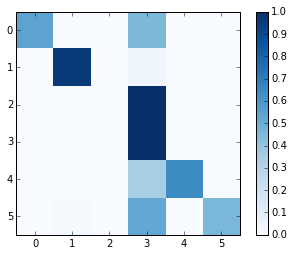

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lable[N_sep:],feat_pred_gnb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

### KNN

We set the n_neighbors = 4.

In [19]:
from sklearn import neighbors
nn = neighbors.KNeighborsClassifier(n_neighbors = 4, weights="uniform")
nn.fit(train_data_features[0:N_sep], lable[0:N_sep])
print nn.score(train_data_features[N_sep:], lable[N_sep:])
feat_pred_nn = nn.predict(train_data_features[N_sep:])

0.476077688299


array([[ 47,   0,   0,   1,  40,   0],
       [  0, 166,   0,   1,   6,   0],
       [  0,   0,   0,   1,  67,   0],
       [  0,   0,   0,  27, 749,   1],
       [  0,   2,   0,   6, 572,   2],
       [  0,   6,   0,  10, 214, 193]])

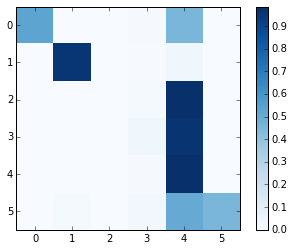

In [20]:
cm = confusion_matrix(lable[N_sep:],feat_pred_nn)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

### SVM

We select the kernel linear.

In [21]:
from sklearn import svm
svm = svm.SVC(kernel='linear')#‘linear!!!’ or 'poly'
svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
print svm.score(train_data_features[N_sep:], lable[N_sep:])
feat_pred_svm = svm.predict(train_data_features[N_sep:])

0.738512553292


array([[ 48,   0,   0,  40,   0,   0],
       [  0, 166,   0,   7,   0,   0],
       [  0,   0,   0,  68,   0,   0],
       [  0,   0,   0, 776,   0,   1],
       [  0,   2,   0, 201, 377,   2],
       [  0,   6,   0, 222,   1, 194]])

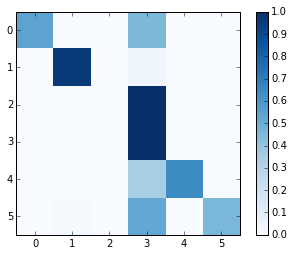

In [22]:
cm = confusion_matrix(lable[N_sep:],feat_pred_gnb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

### Random Forest

We set the n_estimetors = 100.

In [23]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100)
RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
print RF.score(train_data_features[N_sep:], lable[N_sep:])
feat_pred_RF = RF.predict(train_data_features[N_sep:])


0.738512553292


array([[ 47,   0,   0,  41,   0,   0],
       [  0, 166,   0,   7,   0,   0],
       [  0,   0,   0,  68,   0,   0],
       [  0,   0,   0, 776,   0,   1],
       [  0,   0,   0, 201, 377,   4],
       [  0,   6,   0, 222,   2, 193]])

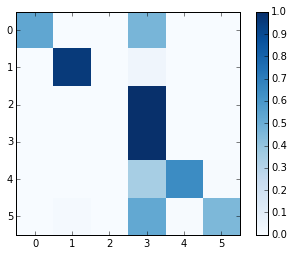

In [24]:
cm = confusion_matrix(lable[N_sep:],feat_pred_RF)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

### Cross Validation for Gaussien NB

In [25]:
from sklearn import cross_validation
scores  = cross_validation.cross_val_score(gnb, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.41102362  0.41417323  0.40472441  0.39527559  0.39527559  0.46214511
  0.44620253  0.43581616  0.43809524  0.709062  ]
0.451179348909


### Cross Validation for KNN

In [26]:
scores  = cross_validation.cross_val_score(nn, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.6992126   0.70393701  0.69606299  0.67716535  0.68661417  0.49842271
  0.45886076  0.47068146  0.47619048  0.49284579]
0.585999331957


### Cross Validation for SVM

In [27]:
scores  = cross_validation.cross_val_score(svm, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.6992126   0.70393701  0.69606299  0.68818898  0.68661417  0.75078864
  0.74208861  0.73217116  0.73333333  0.709062  ]
0.714145949257


### Cross Validation for RF

In [ ]:
scores  = cross_validation.cross_val_score(RF, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

In [52]:
k_gnb = []
k_nn = []
k_svm = []
k_rf = []

for num_feature in range(100,2000,100):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(data_features, lable)
    
    #GNB
    gnb.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_gnb.append(gnb.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #KNN
    nn.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_nn.append(nn.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #SVM  
    svm.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_svm.append(svm.score(train_data_features[N_sep:], lable[N_sep:]))
    
    #RF
    RF.fit(train_data_features[0:N_sep], lable[0:N_sep])
    k_rf.append(RF.score(train_data_features[N_sep:], lable[N_sep:]))
    

    

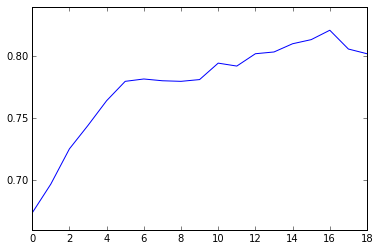

In [53]:
plt.plot(k_gnb)

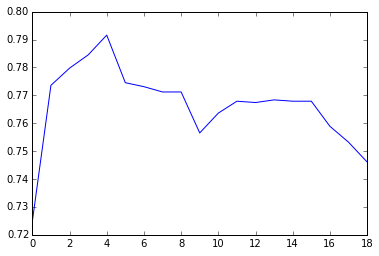

In [54]:
plt.plot(k_nn)

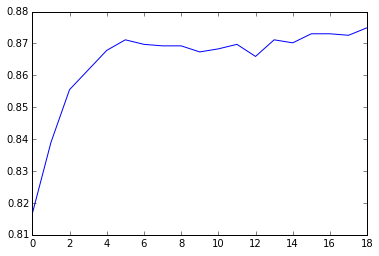

In [55]:
plt.plot(k_svm)

/Users/mimi/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


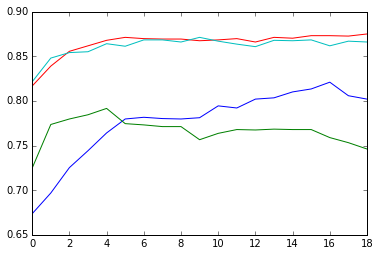

In [63]:
BenchMark = pd.DataFrame({"GNB":k_gnb,'KNN':k_nn,"SVM":k_svm,'RF':k_rf})
BenchMark.index = ["k = "+ str(i) for i in range(100,2000,100)]
BenchMark

,GNB,KNN,RF,SVM
k = 100,0.673614,0.724775,0.821412,0.816675
k = 200,0.696826,0.773567,0.847939,0.838939
k = 300,0.725249,0.779725,0.854098,0.855519
k = 400,0.744197,0.784462,0.855045,0.861677
k = 500,0.764093,0.791568,0.864045,0.867835
k = 600,0.779725,0.774514,0.861203,0.871151
k = 700,0.781620,0.773093,0.868309,0.869730
k = 800,0.780199,0.771198,0.868309,0.869256
k = 900,0.779725,0.771198,0.865940,0.869256
k = 1000,0.781146,0.756514,0.871151,0.867361


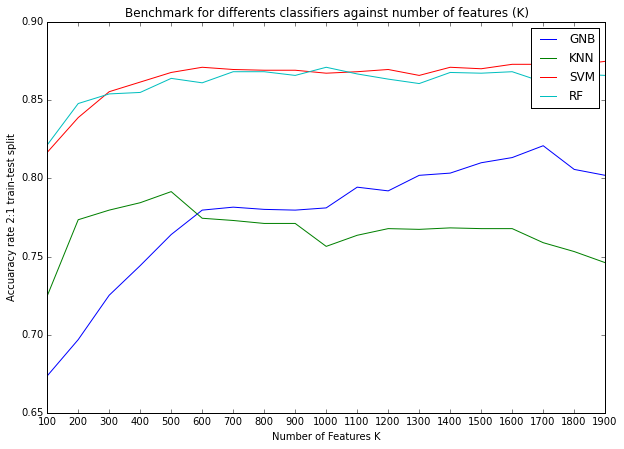

In [78]:
plt.figure(figsize = (10,7))
plt.plot(BenchMark["GNB"])
plt.plot(BenchMark["KNN"])
plt.plot(BenchMark["SVM"])
plt.plot(BenchMark["RF"])
plt.xticks(range(0,19),range(100,2000,100))
plt.legend(['GNB','KNN','SVM','RF'])
plt.xlabel("Number of Features K")
plt.ylabel("Accuaracy rate 2:1 train-test split")
plt.title("Benchmark for differents classifiers against number of features (K)")